In [ ]:
import os
import cv2
import numpy as np
from pathlib import Path
import skimage.io as io
from os.path import exists
from numpy.random import RandomState
import matplotlib.pyplot as plt
from sklearn import decomposition
from skimage.util import random_noise
from skimage import img_as_float
from time import time
import scipy.fftpack as fp
import pywt
import tensorflow as tf
from tensorflow import keras
from sklearn.decomposition import PCA
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from keras.models import load_model
opt = keras.optimizers.Adam(learning_rate = 0.005)
from keras import backend as backend
from PIL import Image


path = '/content/drive/MyDrive/projectdeep/photos'
gray_path = '/content/drive/MyDrive/projectdeep/models'
model_path = '/content/drive/MyDrive/projectdeep/models'

training_data = []

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/MyDrive/projectdeep/zipper/coil-100'
secpath = '/content/drive/MyDrive/projectdeep/zipper/gray'

color = []
gray = []

def makeRgbGrayDatasets():
  for image in os.listdir(path):
    pic = cv2.imread(os.path.join(path,image))
    pic = cv2.cvtColor(pic,cv2.COLOR_BGR2RGB)
    pic = cv2.resize(pic,(252,252))
    graypic = cv2.cvtColor(pic, cv2.COLOR_BGR2GRAY)
    color.append([pic])
    gray.append([graypic])  
  np.save(os.path.join(path,'photos'),np.array(color))
  saved0 = np.load(os.path.join(path,'photos.npy'))
  
  gray = np.array(gray)
  gray = gray.reshape(gray.shape[0],gray.shape[1],gray.shape[2],gray.shape[3],-1)
  np.save(os.path.join(path,'gray_photos'),gray)
  saved1 = np.load(os.path.join(path,'gray_photos.npy'))

In [ ]:
def loadPhoto(path):
    data = np.load(os.path.join(model_path,path))
    data = data[:1100, 0, :,:,:]
    print(data.shape)
    return data


def preprocess(array,col=1):
    size = array.shape[1]
    array= array.astype("float32")/255.0
    if col:
      array=np.reshape(array,(len(array),size,size,3))
    else:
      array=np.reshape(array,(len(array),size,size,1))
    return array

def display(array1,array2,array3,sizes = 0):
    if(sizes == 0):
        sizes = array1.shape[1]
    n=10

    indices = np.random.randint(len(array1),size=n)
    images1 = array1[indices,:]
    images2 = array2[indices,:]
    images3 = array3[indices,:]

    plt.figure(figsize=(20,4))
    for i, (image1,image2,image3) in enumerate(zip(images1,images2,images3)):
        ##
        ax =plt.subplot(5,n,i+1) ##  5 radif , 10 khone , 0 - 10
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.imshow(image1)
        ##
        ax =plt.subplot(5,n,i+1+n) ##  5 radif , 10 khone , 10 - 20
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.imshow(image2)
        ##
        ax =plt.subplot(5,n,i+1+2*n) ##  5 radif , 10 khone , 10 - 20
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.imshow(image3)
        ##
    plt.show()

def load_data():  
    data = loadPhoto('photos.npy')    
    gray_data = loadPhoto('gray_photos.npy')
    train_data = preprocess(data[:1000,:,:])
    gray_train_data= preprocess(gray_data[:1000,:,:],col=0)
    test_data = preprocess(data[1000:1100,:,:])
    gray_test_data= preprocess(gray_data[1000:1100,:,:],col=0)
    return train_data,test_data,gray_train_data,gray_test_data

def loadmodel():
    autoencoder = load_model(f'/content/drive/MyDrive/projectdeep/models/main.h5')
    return autoencoder

def train(train_data,test_data,gray_train_data,gray_test_data,size = 0):
    size = train_data.shape[1]    
    input = layers.Input(shape=(size,size,1))

    x = layers.Conv2D(32,(3,3),activation="relu",padding="same")(input)
    x = layers.MaxPooling2D((2,2),padding="same")(x)
    x = layers.Conv2D(32,(3,3),activation="relu",padding="same")(x)
    x = layers.MaxPooling2D((2,2),padding="same")(x)
    x = layers.Conv2DTranspose(32,(3,3),strides=2,activation="relu",padding="same")(x)
    x = layers.Conv2DTranspose(32,(3,3),strides=2,activation="relu",padding="same")(x)
    x = layers.Conv2D(3,(3,3),activation="sigmoid",padding="same")(x)


    autoencoder = Model(input,x)
    autoencoder.compile(optimizer=opt,loss="binary_crossentropy")
    autoencoder.summary()
    autoencoder.fit(
      x=gray_train_data,
      y=train_data,
      epochs=100,
      batch_size=8,
      shuffle=True,
      validation_data=(gray_test_data,test_data),
    )

    #autoencoder.save(f'/content/drive/MyDrive/projectdeep/models/main.h5')
    return autoencoder

def learnit():
    my_file = Path("/content/drive/MyDrive/projectdeep/models/main.h5")
    if(my_file.is_file()):
      autoencoder = loadmodel()
    else:
      autoencoder = train(train_data,test_data,gray_train_data,gray_test_data)
    return autoencoder

In [ ]:
train_data,test_data,gray_train_data,gray_test_data = load_data()

(1100, 252, 252, 3)
(1100, 252, 252, 1)


In [ ]:
autoencoder = learnit()
predictions = autoencoder.predict(gray_test_data)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 252, 252, 1)]     0         
                                                                 
 conv2d_9 (Conv2D)           (None, 252, 252, 32)      320       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 126, 126, 32)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 126, 126, 32)      9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 126, 126, 32)     9248

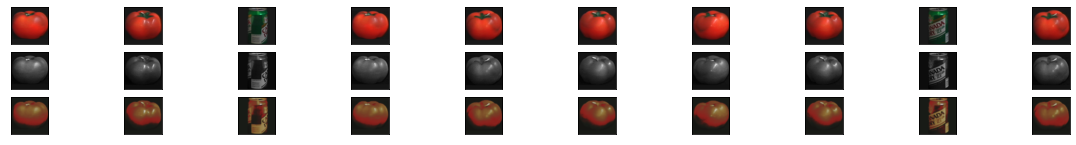

In [ ]:
gray_test_data2 = gray_test_data[:,:,:,0]
display(test_data,gray_test_data2,predictions)